In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('mps')

### Data Loading (Anime Dataset)

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
train_dataset = torchvision.datasets.ImageFolder(root='./data/anime_faces', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)

### Hyperparameters

In [5]:
lr = 3e-4
num_epochs = 5
grad_clip = 1.0
lambda_energy = 0.5
lambda_gp = 10
lambda_reg = 1e-4
sampler_steps = 200
sampler_dt = 1.0 / 200.0

### Basic Flow Model

In [6]:
class FlowModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = self._block(3, 64)
        self.down2 = self._block(64, 128)
        self.down3 = self._block(128, 256)
        self.middle = self._block(256, 256)
        self.up3 = self._block(256, 128)
        self.up2 = self._block(128, 64)
        self.up1 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x, t):
        h1 = self.down1(x)
        h2 = self.down2(h1)
        h3 = self.down3(h2)

        h4 = self.middle(h3)

        h3_up = self.up3(h4 + h3)
        h2_up = self.up2(h3_up + h2)
        h1_up = self.up1(h2_up + h1)
        return h1_up

### Energy Based Model

In [7]:
class EnergyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        energy = self.model(x)
        return torch.clamp(energy, -50, 50)

In [8]:
def compute_gradient_penalty(energy_model, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    energy = energy_model(interpolated)
    grad_outputs = torch.ones_like(energy, requires_grad=False, device=real_samples.device)

    gradients = torch.autograd.grad(outputs=energy, inputs=interpolated, grad_outputs=grad_outputs, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    grad_penalty = (gradients.norm(2, dim=1) - 1).pow(2).mean()
    
    return grad_penalty

### Initialize Models

In [9]:
flow_model = FlowModel().to(device)
energy_model = EnergyModel().to(device)

flow_optimizer = optim.Adam(flow_model.parameters(), lr=1e-4)
ebm_optimizer = optim.Adam(energy_model.parameters(), lr=1e-5)

flow_stop = False
ebm_stop = False

### Training Loop

In [10]:
for epoch in range(num_epochs):
    for batch_idx, (x_real, _) in enumerate(train_loader):
        x_real = x_real.to(device)

        with torch.no_grad():
            t = torch.rand(x_real.size(0), device=device)
            x_noise = torch.randn_like(x_real).to(device)
            x_neg = flow_model(x_noise, t)

        real_energy = energy_model(x_real)
        fake_energy = energy_model(x_neg)

        grad_penalty = compute_gradient_penalty(energy_model, x_real, x_neg)

        ebm_loss = (real_energy.mean() - fake_energy.mean()) + lambda_reg * (real_energy.pow(2).mean() + fake_energy.pow(2).mean()) + lambda_gp * grad_penalty

        if ebm_loss < 0.35:
            ebm_stop = True
        else:
            ebm_optimizer.zero_grad()
            ebm_loss.backward()
            nn.utils.clip_grad_norm_(energy_model.parameters(), max_norm=1.0)
            ebm_optimizer.step()


        t = torch.rand(x_real.size(0), device=device)
        x_noise = torch.randn_like(x_real).to(device)
        xt = (1 - t[:, None, None, None]) * x_noise + t[:, None, None, None] * x_real
        target_v = x_real - x_noise
        pred_v = flow_model(xt, t)

        flow_loss = F.mse_loss(pred_v, target_v)

        if flow_loss < 0.35:
            flow_stop = True
        else:
            flow_optimizer.zero_grad()
            flow_loss.backward()
            # nn.utils.clip_grad_norm_(flow_model.parameters(), max_norm=1.0)
            flow_optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}] Flow Loss: {flow_loss.item():.4f}, EBM Loss: {ebm_loss.item():.4f}")

        if flow_stop and ebm_stop:
            break

    if flow_stop and ebm_stop:
        break

Epoch [1/5] Batch [0] Flow Loss: 1.3696, EBM Loss: 9.9342
Epoch [1/5] Batch [100] Flow Loss: 1.1006, EBM Loss: 9.2224
Epoch [1/5] Batch [200] Flow Loss: 0.9152, EBM Loss: 8.0335
Epoch [1/5] Batch [300] Flow Loss: 0.7402, EBM Loss: 8.2913
Epoch [1/5] Batch [400] Flow Loss: 0.6503, EBM Loss: 5.5351
Epoch [1/5] Batch [500] Flow Loss: 0.5105, EBM Loss: 1.1342
Epoch [1/5] Batch [600] Flow Loss: 0.4685, EBM Loss: -0.0240
Epoch [1/5] Batch [700] Flow Loss: 0.4950, EBM Loss: 0.8167
Epoch [1/5] Batch [800] Flow Loss: 0.4415, EBM Loss: -1.6533
Epoch [1/5] Batch [900] Flow Loss: 0.4761, EBM Loss: -1.9035
Epoch [2/5] Batch [0] Flow Loss: 0.4336, EBM Loss: -0.9664
Epoch [2/5] Batch [100] Flow Loss: 0.4084, EBM Loss: -0.8099
Epoch [2/5] Batch [200] Flow Loss: 0.3734, EBM Loss: -0.9078


In [21]:
torch.save(flow_model.state_dict(), 'flow_model.pth')
torch.save(energy_model.state_dict(), 'energy_model.pth')

In [6]:
flow_model = FlowModel().to(device)
energy_model = EnergyModel().to(device)

flow_model.load_state_dict(torch.load('flow_model.pth', weights_only=True))
energy_model.load_state_dict(torch.load('energy_model.pth', weights_only=True))

<All keys matched successfully>

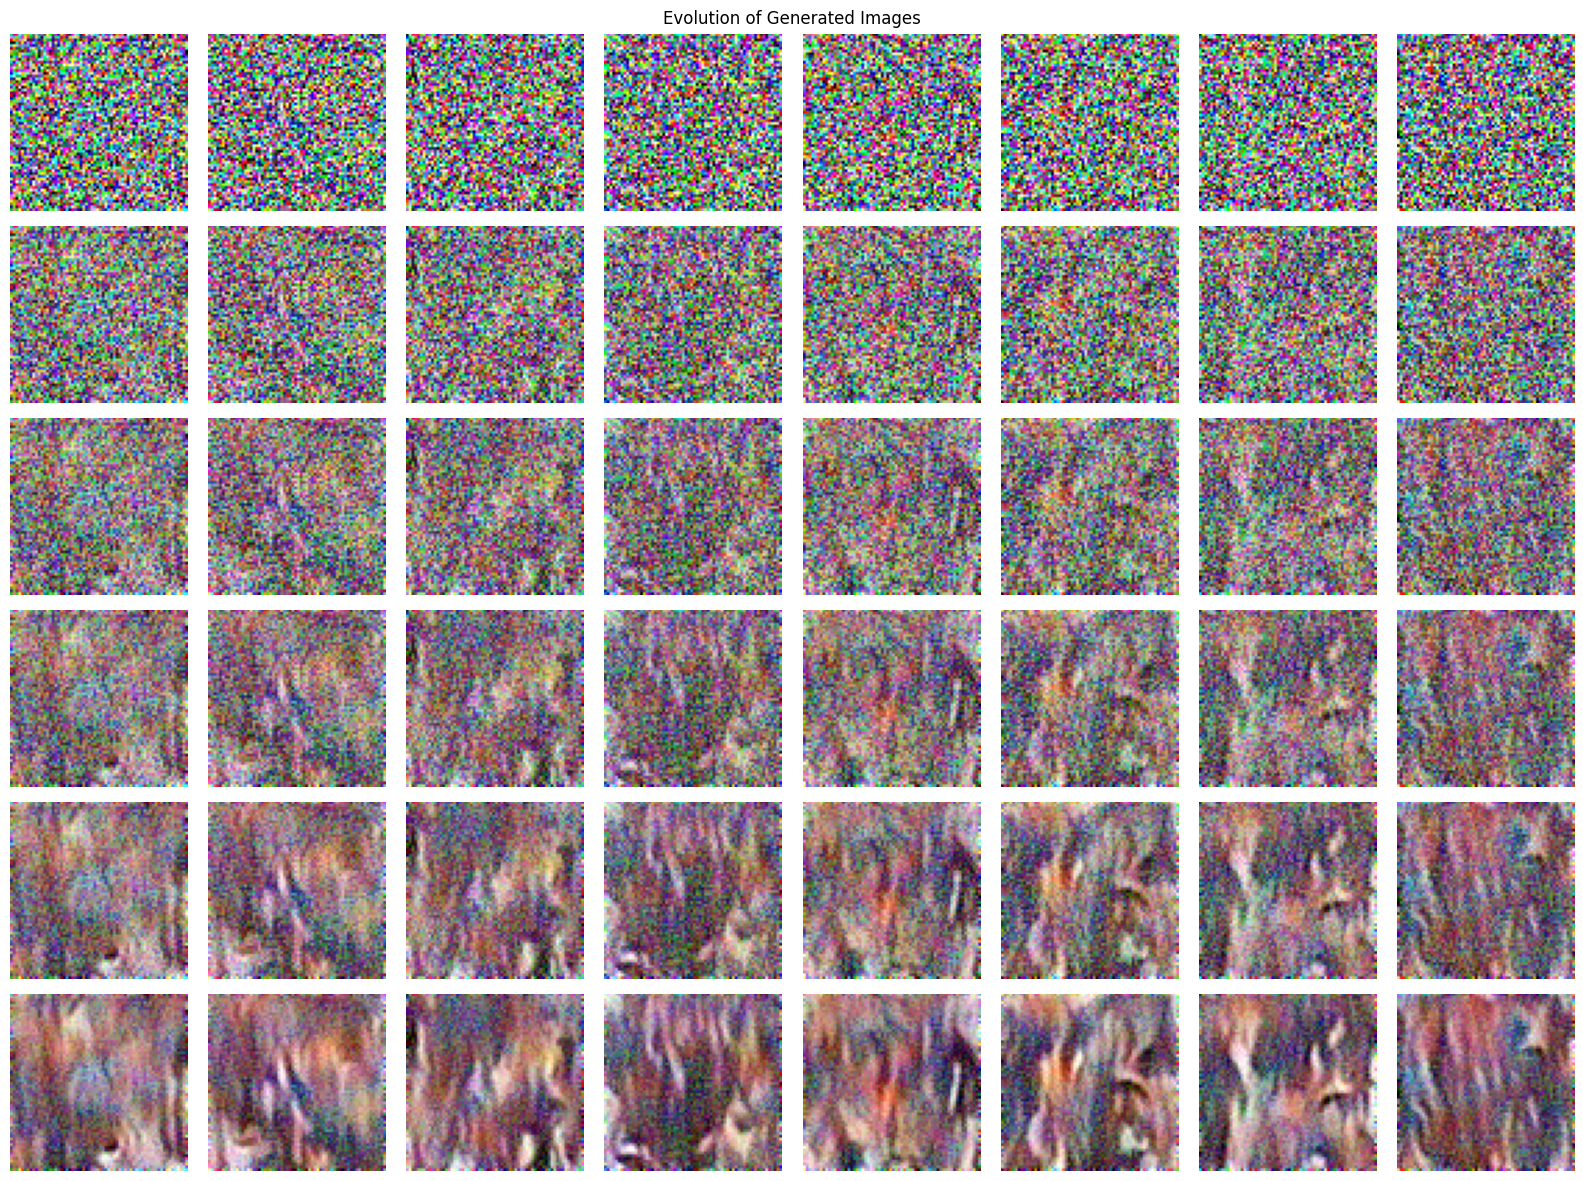

In [11]:
flow_model.eval()
energy_model.eval()

for param in energy_model.parameters():
    param.requires_grad_ = False

num_samples = 8
steps_to_show = 10

z = torch.randn(num_samples, 3, 64, 64, device=device)
traj = [z.detach().cpu().numpy()]


for i in range(sampler_steps):
    t = torch.full((num_samples,), i / sampler_steps, device=device)

    with torch.no_grad():
        v = flow_model(z, t)

    z.requires_grad = True
    energy = energy_model(z).sum()
    grad_z = torch.autograd.grad(energy, z, retain_graph=False, create_graph=False)[0]
    z.requires_grad = False

    z = z + (v - lambda_energy * grad_z) * sampler_dt
    z = torch.clamp(z, -1, 1)

    if (i + 1) % (sampler_steps // 5) == 0:
        traj.append(z.detach().cpu().numpy())

traj = [torch.tensor(t).clamp(-1, 1).add(1).div(2).permute(0, 2, 3, 1).numpy() for t in traj]

fig, axs = plt.subplots(len(traj), num_samples, figsize=(num_samples * 2, len(traj) * 2))

for row in range(len(traj)):
    for col in range(num_samples):
        axs[row, col].imshow(traj[row][col])
        axs[row, col].axis("off")

plt.suptitle("Evolution of Generated Images")
plt.tight_layout()
plt.show()